In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
data = pd.read_csv('SampleFile2.csv')

# Display basic information about the dataset
print(data.info())
print(data.describe())

C:\Users\AbdulRafay\AppData\Local\Temp\ipykernel_13432\3473220776.py:2: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('SampleFile2.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388556 entries, 0 to 388555
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   N+C                     388556 non-null  object 
 1   Shop                    388556 non-null  object 
 2   Region                  388556 non-null  object 
 3   Channel                 388556 non-null  object 
 4   LI                      388556 non-null  object 
 5   Gender                  388556 non-null  object 
 6   Category                388556 non-null  object 
 7   Class                   388556 non-null  object 
 8   Sub-Class               388556 non-null  object 
 9   Season                  388556 non-null  object 
 10  Product Name            388556 non-null  object 
 11  Color                   388556 non-null  object 
 12  Size                    388556 non-null  object 
 13  Size1                   388556 non-null  object 
 14  Color1              

In [3]:
# Parse dates and sort the data by date
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# Extract time-based features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['WeekOfYear'] = data['Date'].dt.isocalendar().week

In [4]:
# Label encode categorical variables
label_encoders = {}
for column in ['Shop', 'Product Name']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

In [5]:
# Define features and target
target = 'Sales Amount'
features = ['Shop', 'Product Name', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear']

In [6]:
# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = train_test_split(data, train_size=train_size, random_state=42)

In [7]:
# Identify high sales months in the training set
train_data['Date'] = pd.to_datetime(train_data['Date'])
monthly_sales = train_data.groupby(['Product Name', 'Shop', train_data['Date'].dt.month])['Sales Amount'].sum().reset_index()
high_sales_months = monthly_sales.groupby(['Product Name', 'Shop'])['Sales Amount'].transform(lambda x: x > x.mean())
monthly_sales['high_sales'] = high_sales_months.astype(int)

In [8]:
# Merge the high_sales feature back to the train_data
train_data = train_data.merge(
    monthly_sales[['Product Name', 'Shop', 'Date', 'high_sales']], 
    left_on=['Product Name', 'Shop', 'Month'], 
    right_on=['Product Name', 'Shop', 'Date'],
    how='left'
)

In [9]:
train_data = train_data.drop(columns=['Date_y']).rename(columns={'Date_x': 'Date'})
train_data['high_sales'] = train_data['high_sales'].fillna(0).astype(int)

In [10]:
# Set high_sales feature in the test set based on the training set high sales months
test_data['high_sales'] = 0
for _, row in monthly_sales[high_sales_months].iterrows():
    test_data.loc[(test_data['Product Name'] == row['Product Name']) & 
                  (test_data['Shop'] == row['Shop']) & 
                  (test_data['Month'] == row['Date']), 'high_sales'] = 1

In [12]:
# Handle missing values by filling forward and backward
train_data = train_data.bfill().ffill()
test_data = test_data.bfill().ffill()

# Ensure there's still data available
if train_data.empty or test_data.empty:
    raise ValueError("No data available after handling missing values. Check your dataset.")

In [13]:
# Define features and target for training and testing
X_train = train_data[features + ['high_sales']]
y_train = train_data[target]
X_test = test_data[features + ['high_sales']]
y_test = test_data[target]


In [14]:
# Ensure there is enough data to train the model
if len(X_train) == 0 or len(X_test) == 0:
    raise ValueError("Insufficient data to train the model. Adjust the train/test split or check your dataset.")


In [15]:
# Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [16]:
# Make predictions
y_pred = model.predict(X_test)

In [17]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 160.7941556936055


In [18]:
# Feature importance
importances = model.feature_importances_
feature_importances = pd.DataFrame({'Feature': features + ['high_sales'], 'Importance': importances})
print(feature_importances.sort_values(by='Importance', ascending=False))

        Feature  Importance
1  Product Name    0.717228
2          Year    0.121802
6    WeekOfYear    0.094554
0          Shop    0.027116
4           Day    0.018277
5     DayOfWeek    0.010154
3         Month    0.005700
7    high_sales    0.005170


In [ ]:
# # Save the model
# joblib.dump(model, 'random_forest_model_with_high_sales_no_festive.pkl')

In [19]:
# Plotting
plt.figure(figsize=(15, 10))


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Feature Importances')

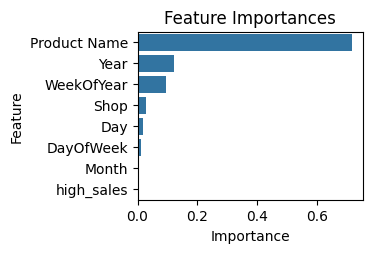

In [20]:
# Plot feature importance
plt.subplot(2, 2, 1)
sns.barplot(x='Importance', y='Feature', data=feature_importances.sort_values(by='Importance', ascending=False))
plt.title('Feature Importances')

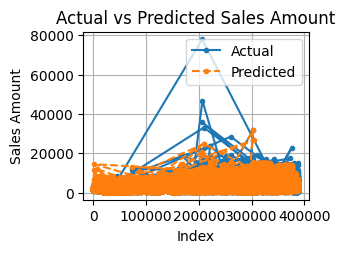

In [21]:
# Plot actual vs predicted
plt.subplot(2, 2, 2)
plt.plot(y_test.index, y_test.values, label='Actual', marker='o', linestyle='-', markersize=3)
plt.plot(y_test.index, y_pred, label='Predicted', marker='o', linestyle='--', markersize=3)
plt.legend()
plt.title('Actual vs Predicted Sales Amount')
plt.xlabel('Index')
plt.ylabel('Sales Amount')
plt.grid(True)


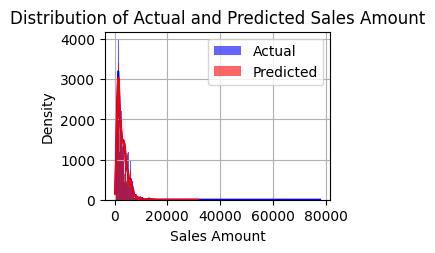

In [22]:
# Plot distribution of actual and predicted values
plt.subplot(2, 2, 3)
sns.histplot(y_test, kde=True, color='blue', label='Actual', alpha=0.6)
sns.histplot(y_pred, kde=True, color='red', label='Predicted', alpha=0.6)
plt.legend()
plt.title('Distribution of Actual and Predicted Sales Amount')
plt.xlabel('Sales Amount')
plt.ylabel('Density')
plt.grid(True)

Text(0.5, 1.0, 'Distribution of Residuals')

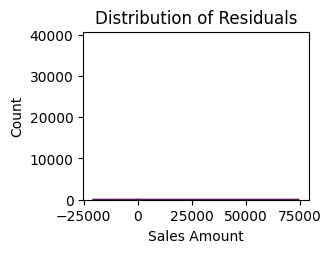

In [23]:
# Plot residuals
residuals = y_test - y_pred
plt.subplot(2, 2, 4)
sns.histplot(residuals, kde=True, color='purple')
plt.title('Distribution of Residuals')